# Introduction

In [18]:
# https://huggingface.co/mlx-vision/vit_base_patch14_518.dinov2-mlxim

from mlxim.model import create_model
from mlxim.io import read_rgb
from mlxim.transform import ImageNetTransform
import mlx.core as mx

from mlxim.model import create_model
import mlx.core as mx
import mlx.nn as nn
from mlxim.transform import ImageNetTransform
from mlxim.data import FolderDataset, DataLoader
from mlxim.io import read_rgb
from matplotlib import pyplot as plt
import numpy as np
import cv2
import random
from mlxim.io import read_rgb
import torch
import torch.nn.functional as F
import os

transform = ImageNetTransform(train=False, img_size=518)
x = transform(read_rgb("/home/osero/Desktop/CMPE/dinov2/my_test/cat.jpg"))
x = mx.expand_dims(mx.array(x), 0)

model = create_model("vit_base_patch14_518.dinov2")
model.eval()

logits, attn_masks = model(x, attn_masks=True)
attn = attn_masks[-1]

In [19]:
# setting some parameters
_, w, h, _ = x.shape

patch_size = model.patch_size

w_featmap = w // patch_size
h_featmap = h // patch_size

w = w - w % patch_size
h = h - h % patch_size

# Plot single attention maps

In [21]:
# apply some threshold to get only most of the attention masses
# threshold = 0.3
threshold = None

# switching to torch because it's easier to work with
attentions = torch.tensor(np.array(attn))

nh = attentions.shape[1]  # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

th_attn = None
if threshold is not None:
    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - threshold)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate
    th_attn = F.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().cpu().numpy()

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = F.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().cpu().numpy()

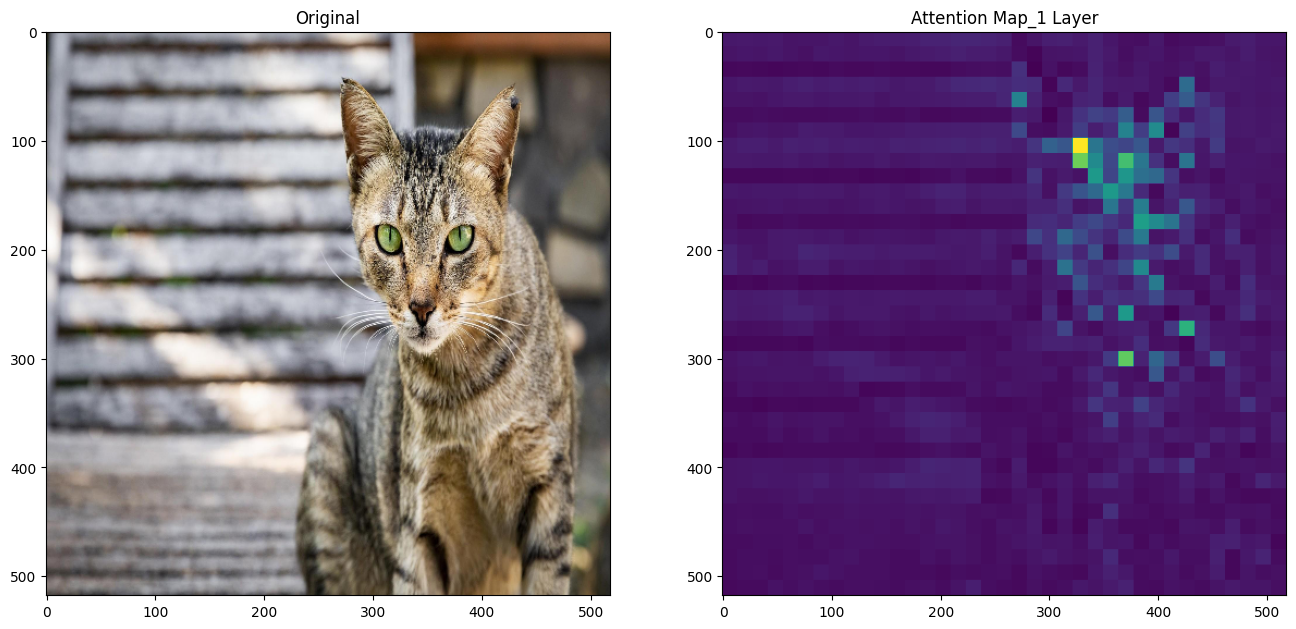

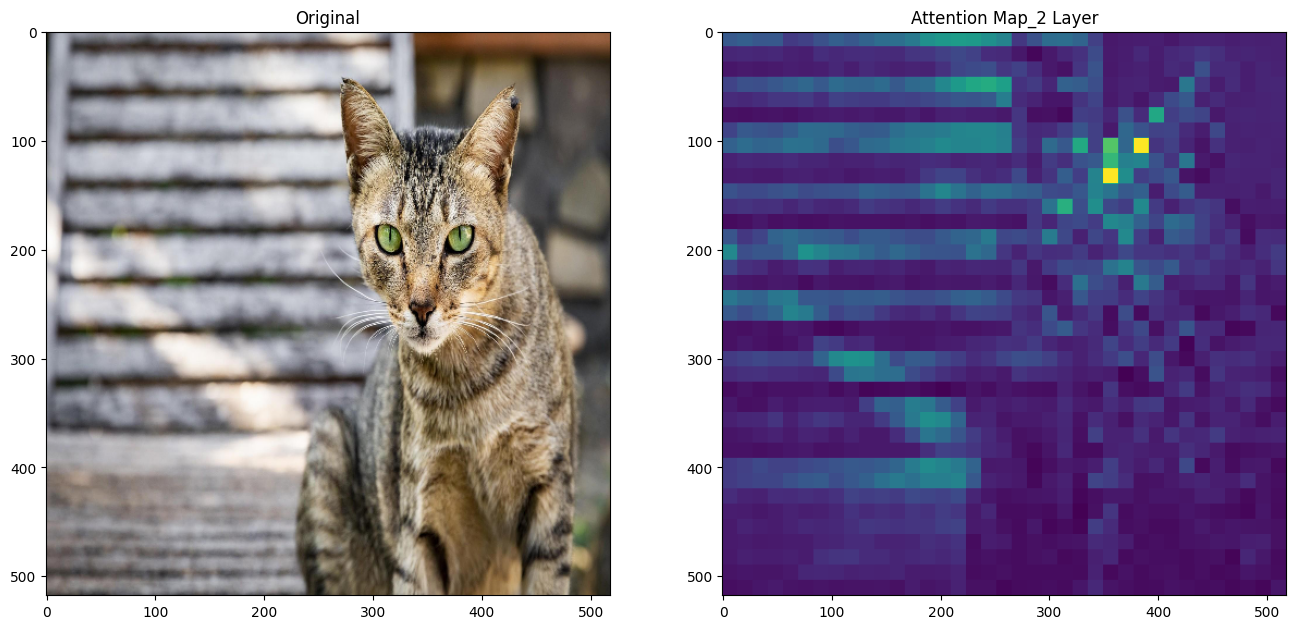

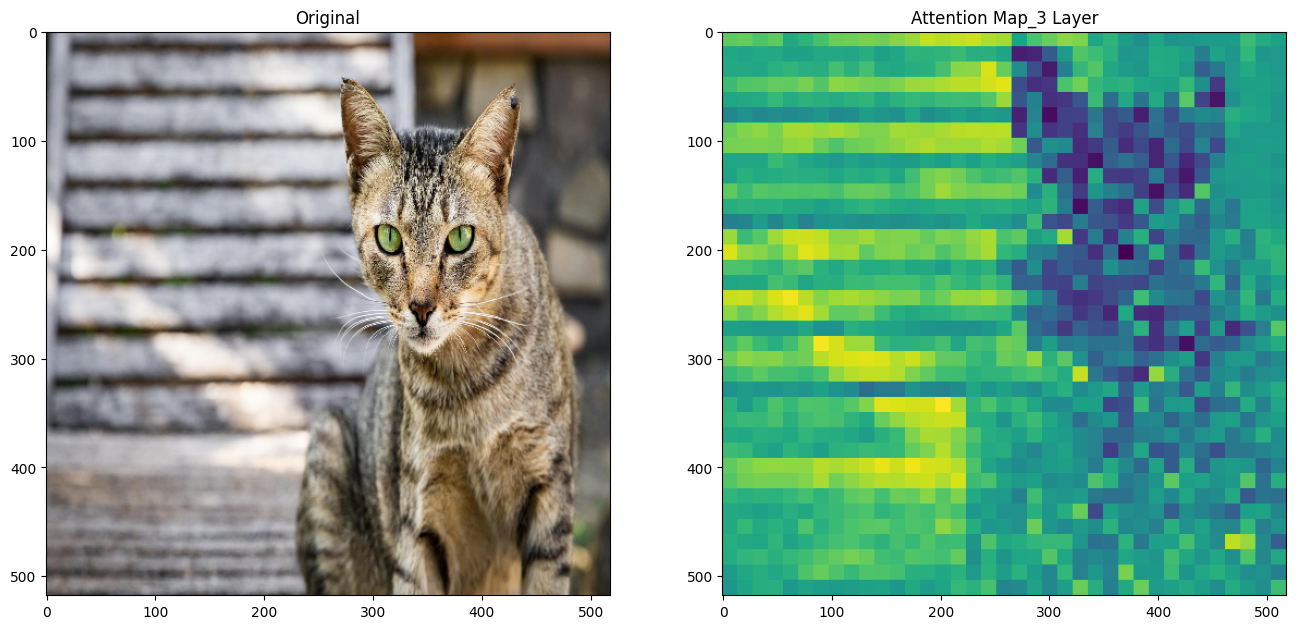

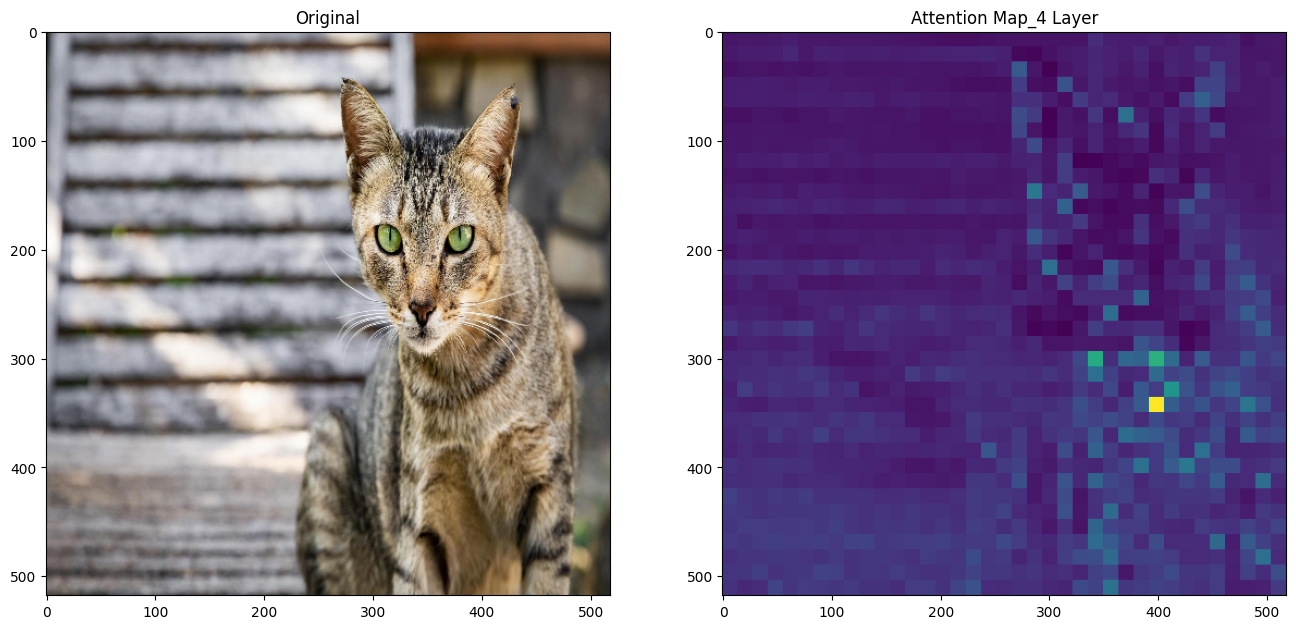

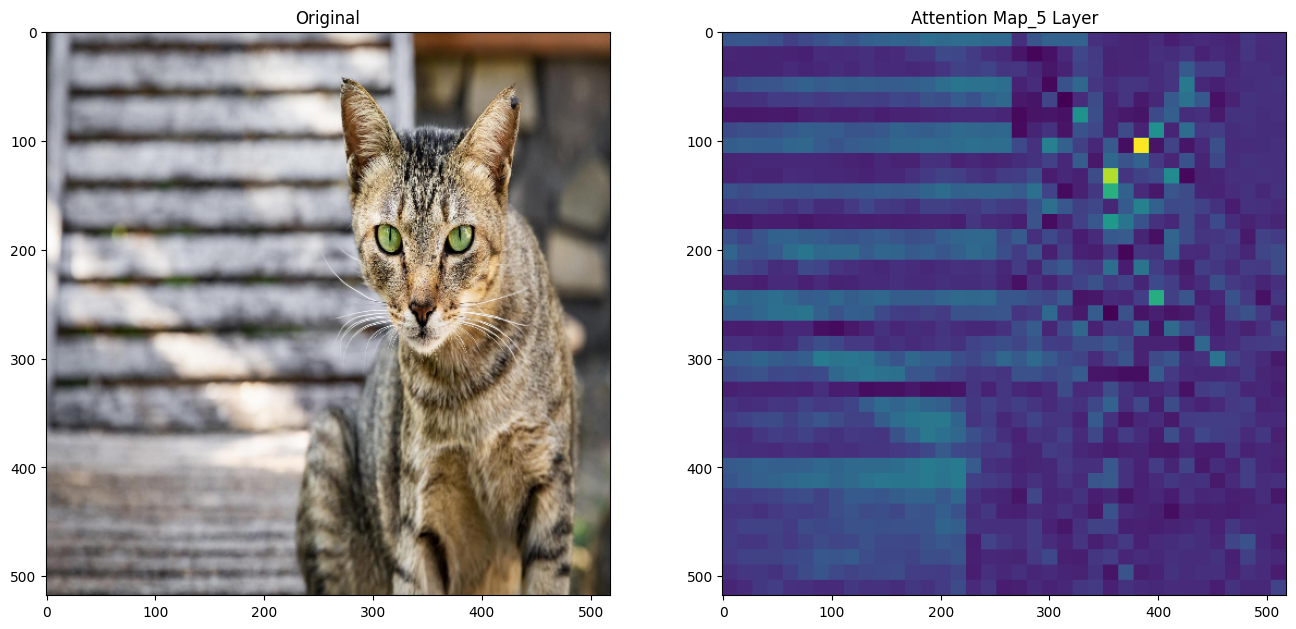

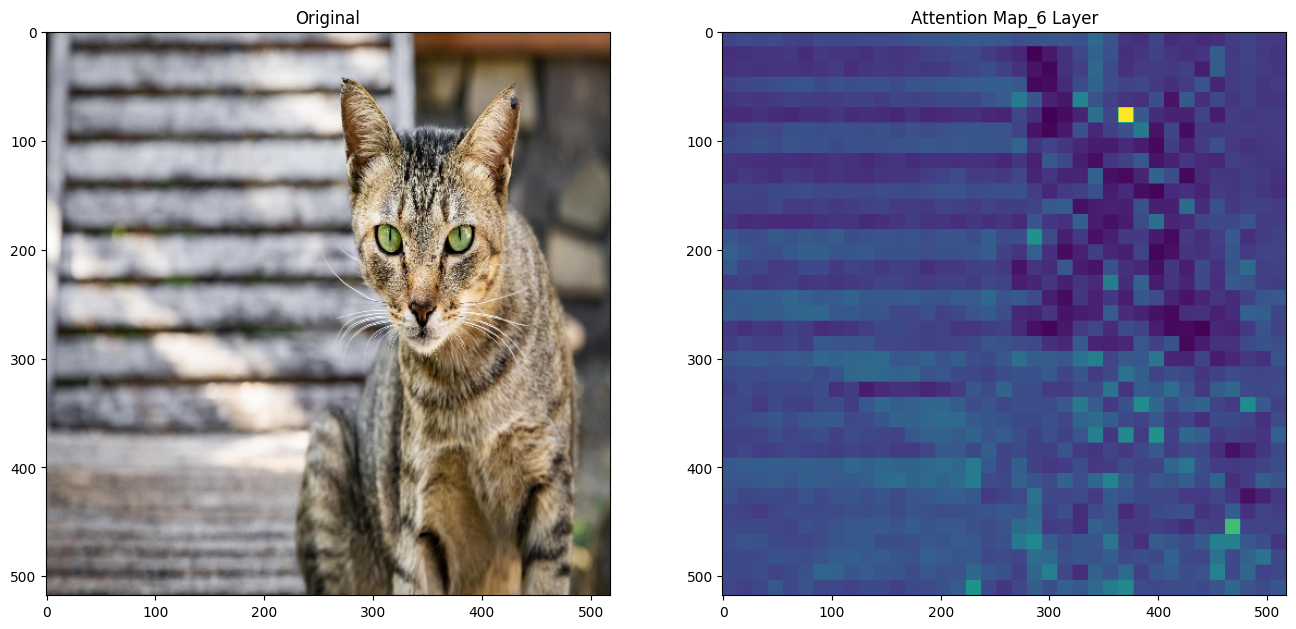

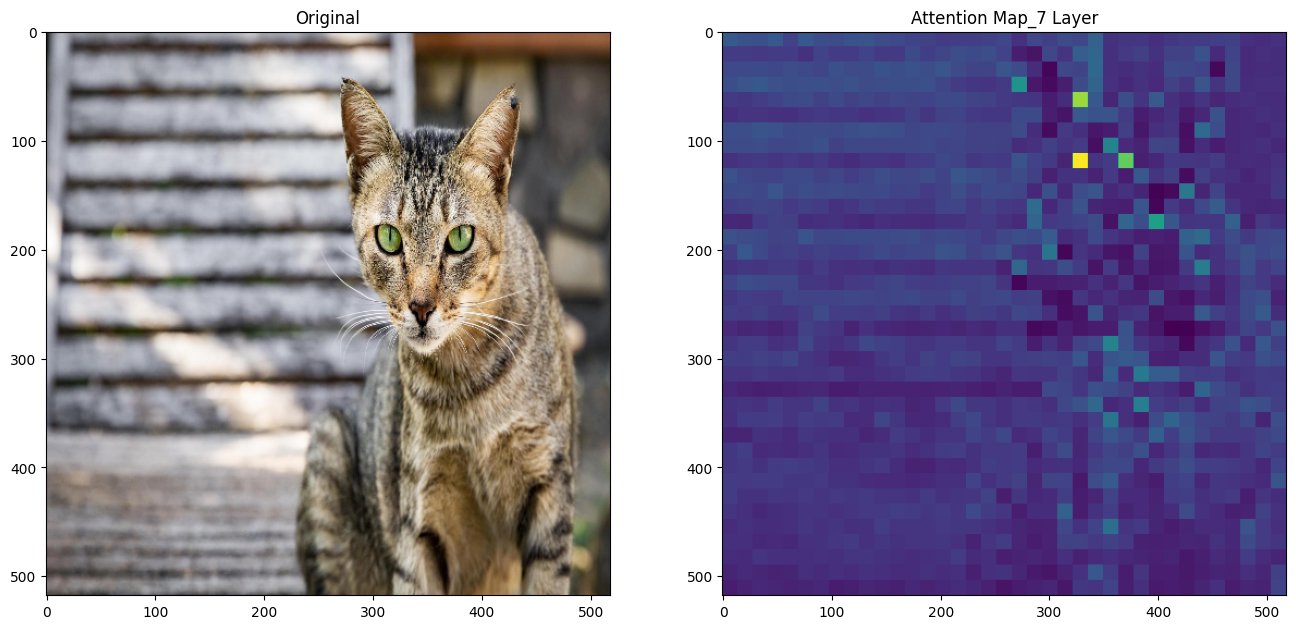

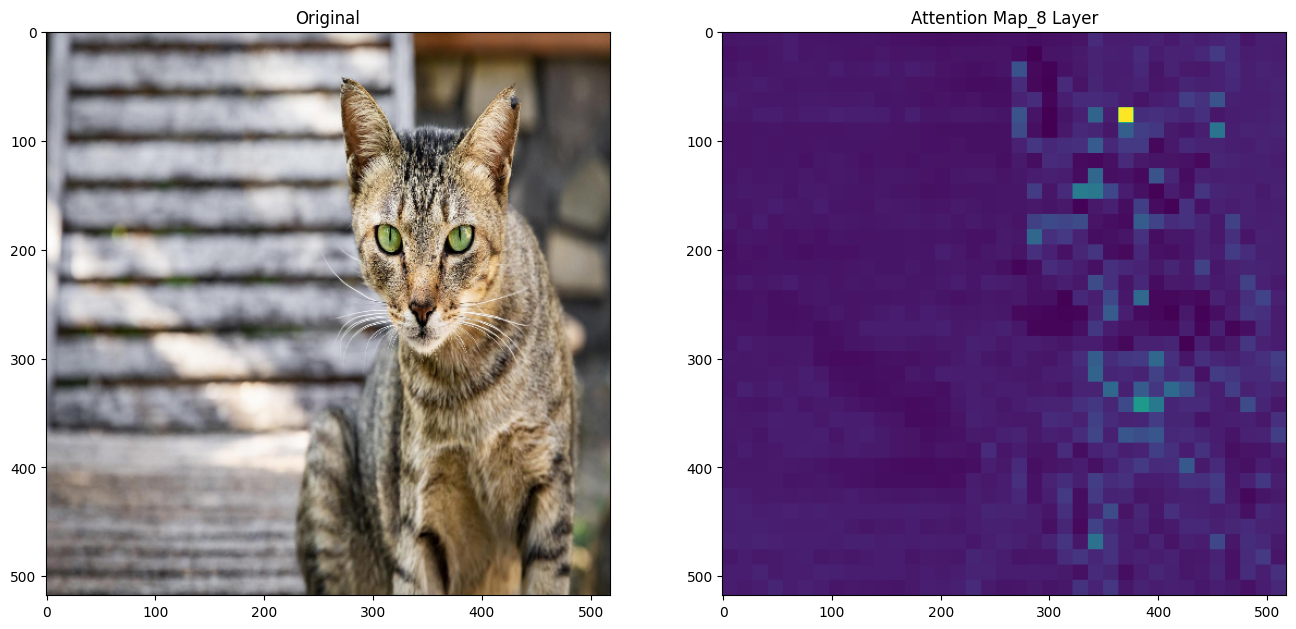

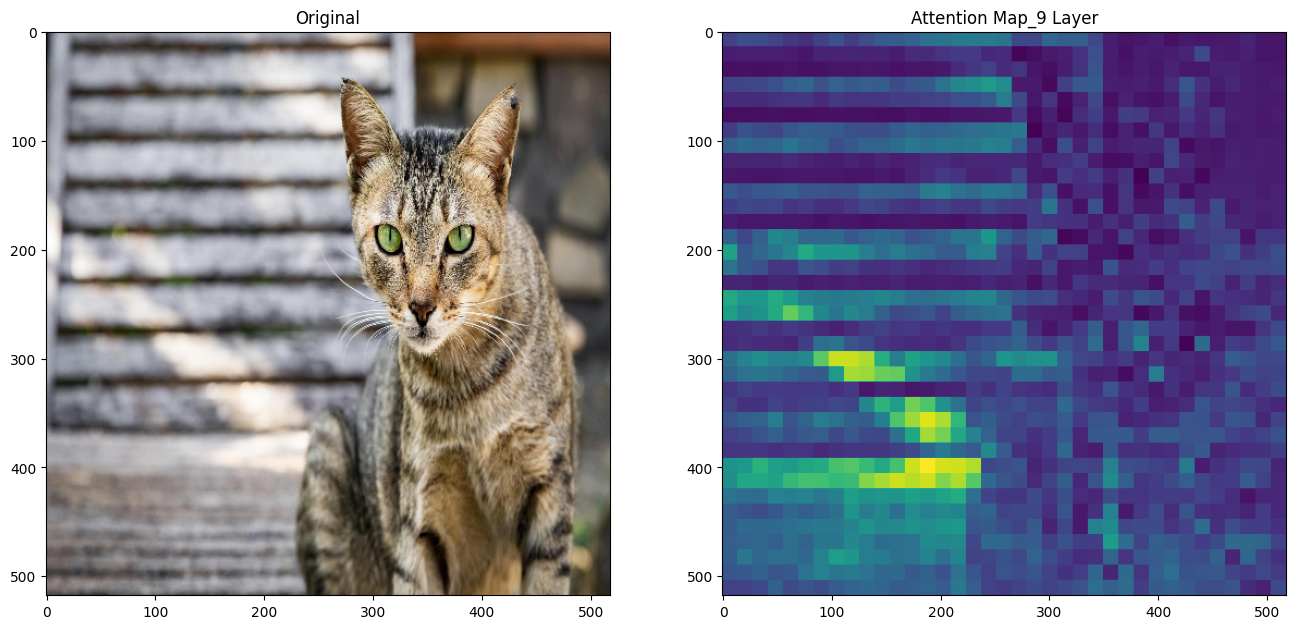

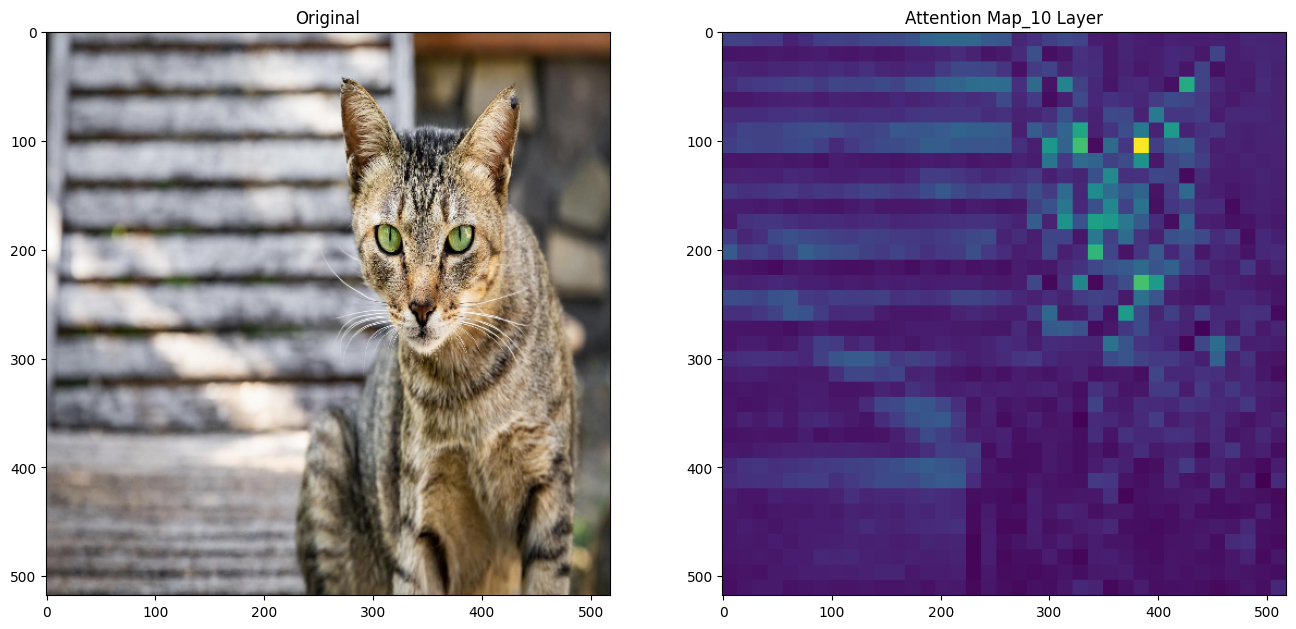

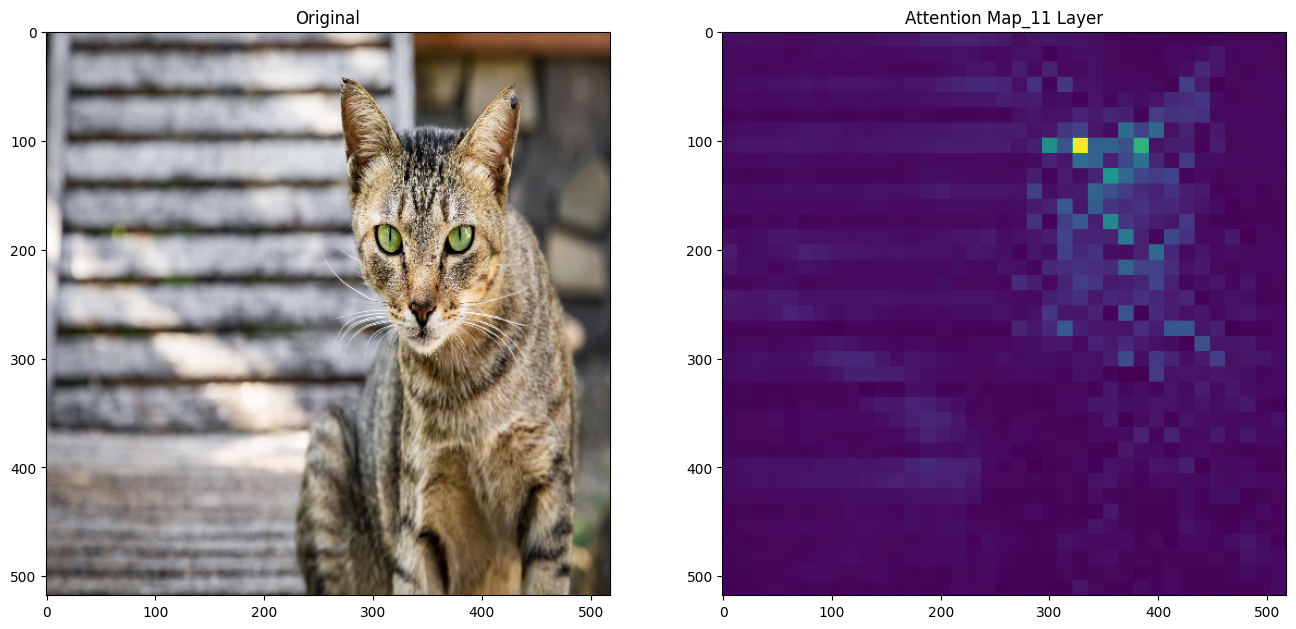

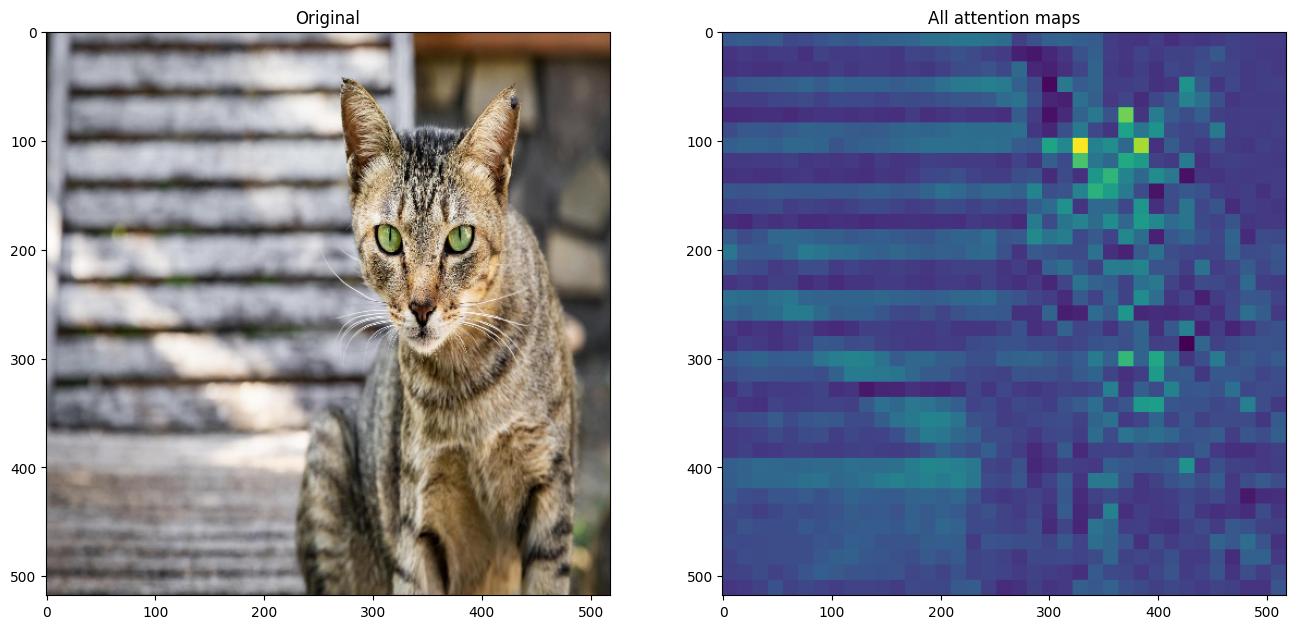

In [22]:
if th_attn is not None:
    attentions = th_attn

img = read_rgb("/home/osero/Desktop/CMPE/dinov2/my_test/cat.jpg")
img = cv2.resize(img, (w, h))
for i, v in enumerate(attentions):
    # Attention from the output token to the input space.
    # mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = v[..., np.newaxis]
    # result = (mask / mask.max() * img).astype("uint8")
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title("Original")
    ax2.set_title("Attention Map_%d Layer" % (i + 1))
    _ = ax1.imshow(img)
    _ = ax2.imshow(mask / mask.max())

# Summing up all the attention maps
ax1.set_title("Original")
ax2.set_title("All attention maps")
_ = ax1.imshow(img)
mask = np.sum(attentions, axis=0)
_ = ax2.imshow(mask / mask.max())